# Frozen Lake 

In [24]:
import numpy as np
import gymnasium as gym
from IPython import display
import matplotlib.pyplot as plt
from typing import *

## Creating Environment

In [2]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array")
env.reset()

(0, {'prob': 1})

Average rewards:  0.0


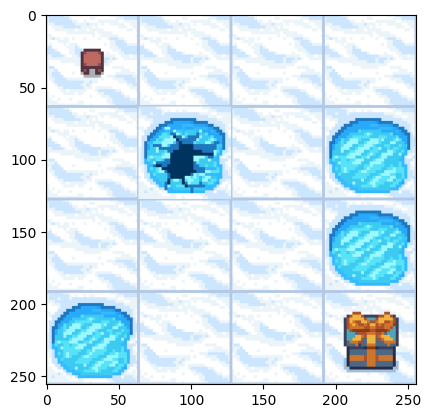

In [3]:
rewards = [0]
states = [0]
actions = []
for i in range(100):
    
    action = env.action_space.sample()
    (obs, r, term, trunc, _) = env.step(action)
    actions.append(action)
    states.append(obs)
    rewards.append(r)
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if term:
        print("Average rewards: ", np.mean(rewards))
        env.reset()
        break

In [28]:
def run_an_episode(env, max_steps: int = 500, render: bool = False, policy: np.ndarray | Callable =None):
    rewards = []
    states = []
    actions = []
    obs = 0
    for _ in range(max_steps):
    
        action = policy(obs) if isinstance(policy, Callable) else policy[obs] if policy is not None else env.action_space.sample()
        obs, r, term, trunc, _ = env.step(action)
        actions.append(action)
        states.append(obs)
        rewards.append(r)

        if render: 
            plt.imshow(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)

        if term or trunc: break
        

    env.reset()
    return states, actions, rewards


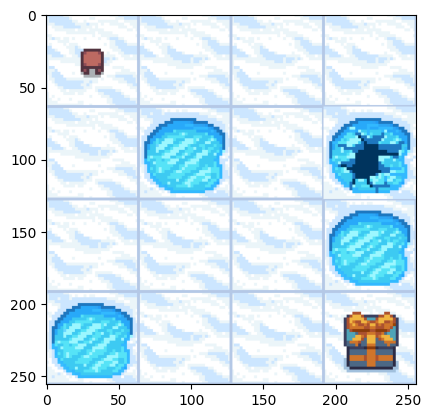

In [5]:
state,actions, rewards = run_an_episode(env, render=True)

# First Visit MC Prediction

In [6]:
value_table = np.zeros(env.observation_space.n, np.float64)
state_count = np.zeros(env.observation_space.n, np.int32)
state_updated_in_the_episode = np.full((env.observation_space.n, ), False, bool)
def get_discounted_returns(rewards, gamma):
    def get_return(i, l):
        return sum(map(lambda x: x[1] * gamma ** x[0], enumerate(l[i:])))
    
    return list(map(lambda x: get_return(x, rewards), range(0, len(rewards))))

for k in range(10000):
    states, actions, rewards = run_an_episode(env)
    returns = get_discounted_returns(rewards, 0.6)
    for (state, action, ret) in zip(states, actions, returns):
        if np.all(state_updated_in_the_episode): break
        if not state_updated_in_the_episode[state]:
            value_table[state] += ret
            state_count[state] += 1
            state_updated_in_the_episode[state] = True
    
    
    state_updated_in_the_episode.fill(False)
    
masked_state_count = np.ma.masked_equal(state_count, 0)
state_values = np.ma.filled(value_table / masked_state_count ,0.0)


In [7]:
print(state_values)

[1.25122042e-04 1.48344179e-04 7.31984345e-04 1.11459353e-04
 3.75772732e-04 0.00000000e+00 3.70473823e-03 0.00000000e+00
 1.87976048e-03 1.05565766e-02 2.73187601e-02 0.00000000e+00
 0.00000000e+00 3.99912025e-02 1.80897568e-01 1.00000000e+00]


## Every Visit Monte Carlo

In [8]:
value_table = np.zeros(env.observation_space.n, np.float64)
state_count = np.zeros(env.observation_space.n, np.int32)

for k in range(10000):
    states, actions, rewards = run_an_episode(env)
    returns = get_discounted_returns(rewards, 0.6)
    for (state, action, ret) in zip(states, actions, returns):
        value_table[state] += ret
        state_count[state] += 1
    
    
    
masked_state_count = np.ma.masked_equal(state_count, 0)
state_values = np.ma.filled(value_table / masked_state_count ,0.0)


In [9]:
print(state_values)

[1.19106770e-04 1.65600858e-04 8.11361690e-04 2.20716933e-04
 3.68229494e-04 0.00000000e+00 4.05304035e-03 0.00000000e+00
 1.77733696e-03 9.04585813e-03 2.71682001e-02 0.00000000e+00
 0.00000000e+00 3.29969152e-02 1.83969421e-01 1.00000000e+00]


## Action Value Prediction  

In [10]:
q_table = np.zeros((env.observation_space.n, env.action_space.n), np.float64)
state_action_count = np.zeros((env.observation_space.n, env.action_space.n), np.int32)

for k in range(10000):
    states, actions, rewards = run_an_episode(env)
    returns = get_discounted_returns(rewards, 0.6)
    for (state, action, ret) in zip(states, actions, returns):
        q_table[state, action] += ret
        state_action_count[state, action] += 1
    
masked_state_action_count = np.ma.masked_equal(state_action_count, 0)
q_table = np.ma.filled(q_table / masked_state_action_count ,0.0)
# Action value for terminal state should be zero
q_table[-1].fill(0.0)


In [11]:
print(q_table)

[[8.74935809e-05 9.45664568e-05 1.38353540e-04 1.28375698e-04]
 [1.37856353e-04 1.91206209e-04 2.04115347e-04 1.36643134e-04]
 [8.20402357e-04 1.01953017e-03 7.00504858e-04 1.03024962e-03]
 [3.52991730e-06 3.94059404e-04 2.49761817e-04 4.74568481e-04]
 [4.98149653e-04 3.27019714e-04 2.56372155e-04 2.50308097e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.39762807e-03 4.86614625e-03 5.09219446e-03 2.57142857e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.69360518e-03 1.84477779e-03 1.85350664e-03 1.37140364e-03]
 [6.14873872e-03 1.03121510e-02 1.00166297e-02 9.56171694e-03]
 [3.00037476e-02 3.10096483e-02 3.17344926e-02 3.01870558e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.83873320e-02 3.00390455e-02 2.77535651e-02 4.75330909e-02]
 [1.83430039e-01 2.09065137e-01 1.89907617e-01 1.64517917e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

# Monte Carlo Control

### Initialize Random Policy, Q-table and Counting Table

In [67]:
approximate_policy = np.random.rand(env.observation_space.n, env.action_space.n)

def epislon_greedy_policy(policy, epsilon):

    def policy_fn(state):
        action_space = policy[state]
        if np.random.rand() < epsilon:
            return np.random.choice(range(len(action_space)))
        return np.argmax(action_space)


    return policy_fn



q_table = np.zeros((env.observation_space.n, env.action_space.n), np.float64)
state_action_count = np.zeros((env.observation_space.n, env.action_space.n), np.int32)
return_table = np.zeros((10000, *q_table.shape))

accumulated_return_table = np.zeros((env.observation_space.n, env.action_space.n), np.float64) 
epsilon = 0.7
gamma = 0.9
for i in range(100000):
    updated_policy = np.copy(approximate_policy)
    states, actions, rewards = run_an_episode(env, policy=epislon_greedy_policy(q_table, epsilon))
    for state, action, ret in zip(states, actions, get_discounted_returns(rewards, gamma)):
        accumulated_return_table[state, action] += ret
        state_action_count[state, action] += 1
        # return_table[i, state, action] = ret

    # Estimate the value 
    q_table = np.ma.filled(accumulated_return_table / np.ma.masked_equal(state_action_count, 0.0), 0.0)
    # q_table = return_table.mean(axis=0)
    best_actions = np.argmax(q_table, axis=1)
    
    # Update the policy
    q_table = np.ma.filled((sum(rewards) - q_table  ) / np.ma.masked_equal(state_action_count, 0.0), 0.0)

    # new_policy[:, best_actions] += 1 - epsilon



    # approximate_policy = new_policy

print(approximate_policy)

[[0.55184178 0.27128886 0.29520057 0.62149489]
 [0.28333872 0.19432722 0.48154547 0.59704522]
 [0.44731857 0.58668188 0.44212466 0.36642533]
 [0.83296113 0.80095658 0.54169715 0.55722058]
 [0.59193687 0.48993712 0.44283652 0.94536066]
 [0.14595069 0.59231346 0.26641158 0.6676138 ]
 [0.02741141 0.59450609 0.69550137 0.14802898]
 [0.90406797 0.08177145 0.60587062 0.26055488]
 [0.30092555 0.32593272 0.1182705  0.63434411]
 [0.03537566 0.73923575 0.71552085 0.68444279]
 [0.93748408 0.61202846 0.02464224 0.14091566]
 [0.37755088 0.69643895 0.18114905 0.21290217]
 [0.40316577 0.38913571 0.28819771 0.18694884]
 [0.40699873 0.53078014 0.60699248 0.55636636]
 [0.36271015 0.43821521 0.23075258 0.09682841]
 [0.89651107 0.8844245  0.88343729 0.84625617]]


In [68]:
print(np.argmax(q_table, axis=1) )

[0 3 3 3 0 0 0 0 0 3 3 0 0 0 1 0]


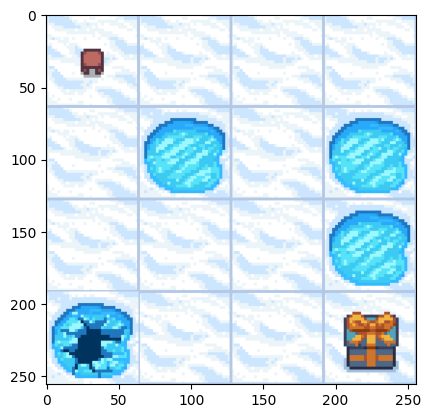

In [69]:
_ = run_an_episode(env, policy=epislon_greedy_policy(q_table, 0.0), render=True)